# Importing the Libraries

In [66]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize, LinearConstraint, Bounds
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt

# Function to download the closing prices of the stocks

In [26]:
def download_data(ticker_list, start_date, end_date):
    data = {}
    start = start_date
    end = end_date
    for ticker in ticker_list:
        df = yf.download(ticker,start, end, period = '1d' )
        data[ticker] = df['Adj Close']
        main_data = pd.DataFrame.from_dict(data)
    return main_data

In [27]:
tickers = ['RTO', 'NVO', 'KR', 'BURL', 'AGR', 'ARHS', 'ASX', 'AAPL', 'MSFT', 'META', 'DKNG', 'PLTR']
    
stock_data = download_data(tickers, '2023-03-01', '2024-03-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Stocks along with their closing prices

In [28]:
stock_data.head(10)

RTO        NVO         KR        BURL        AGR       ARHS  \
Date                                                                            
2023-03-01  29.892561  70.017914  42.119888  217.110001  35.700932  13.509293   
2023-03-02  29.775602  70.380608  44.401619  212.000000  36.338112  13.470639   
2023-03-03  30.165464  71.017746  44.644360  216.210007  36.825371  13.702559   
2023-03-06  29.999771  70.949135  45.129833  218.740005  36.956547  12.852189   
2023-03-07  29.843828  70.537437  45.547340  214.490005  36.310001  12.668586   
2023-03-08  30.214195  69.331764  46.071659  215.309998  36.844109  12.369024   
2023-03-09  30.613804  69.611115  45.877464  207.160004  36.375595   9.895219   
2023-03-10  29.921801  69.248428  45.731819  209.250000  35.654079   9.122155   
2023-03-13  29.804840  68.880844  45.489086  204.899994  36.319374   8.542357   
2023-03-14  30.194702  70.062027  45.809502  212.539993  36.572369   8.532694   

                 ASX        AAPL        MSFT        META       DKNG  PLTR  
Date                                                                       
2023-03-01  6.773444  144.538513  243.825455  173.236191  18.320000  7.69  
2023-03-02  6.894732  145.135315  248.617401  174.345016  18.580000  7.97  
2023-03-03  6.969370  150.228119  252.755905  185.053650  19.040001  8.33  
2023-03-06  6.885402  153.013275  254.320236  184.704025  19.190001  8.28  
2023-03-07  6.885402  150.795120  251.627228  184.314438  19.360001  8.28  
2023-03-08  7.062668  152.058365  251.181686  184.773956  19.580000  8.13  
2023-03-09  6.829423  149.790466  249.815414  181.497437  18.740000  7.69  
2023-03-10  6.736125  147.711578  246.122437  179.319733  18.549999  7.35  
2023-03-13  6.838753  149.671112  251.399506  180.708267  18.219999  7.87  
2023-03-14  6.978700  151.779831  258.201355  193.814362  18.080000  7.89

# Stationarity Test for the stock prices
**The following values are the probabilities that the given stock is not stationary**

In [29]:
Stationarity_values = []
for i in stock_data.columns:
    p = sts.adfuller(stock_data[i])[1]
    Stationarity_values.append(p)
np.transpose(Stationarity_values)

array([0.71902674, 0.87343033, 0.06375957, 0.52874404, 0.60655141,
       0.28695009, 0.78114099, 0.04196179, 0.72708123, 0.99271963,
       0.82690026, 0.75073151])

# Visualizing Stock Fluctuations

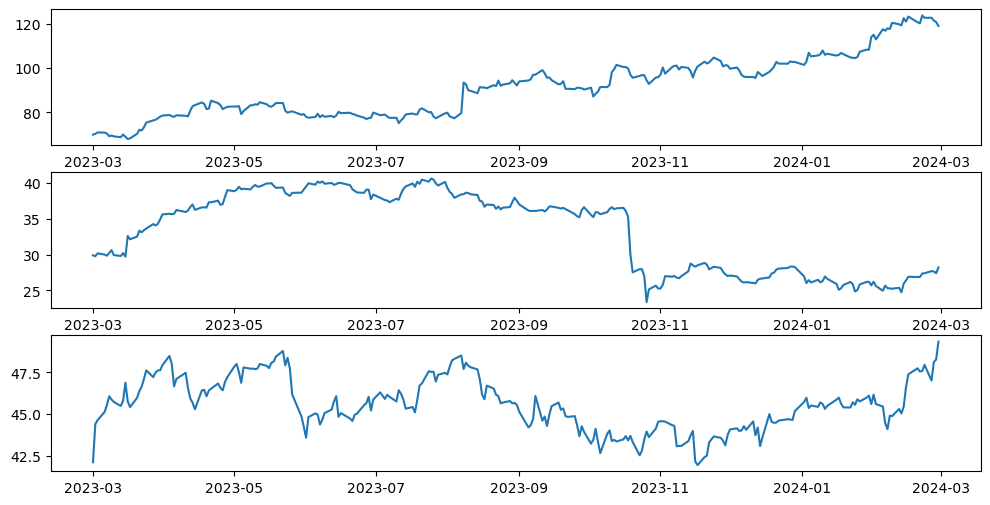

In [45]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)


ax1.plot(stock_data.NVO)
ax2.plot(stock_data.RTO)
ax3.plot(stock_data.KR)

# Checking for the correlation between past and present values

## Auto Correlation Function

This function determines the correlation between the current value and the previous values

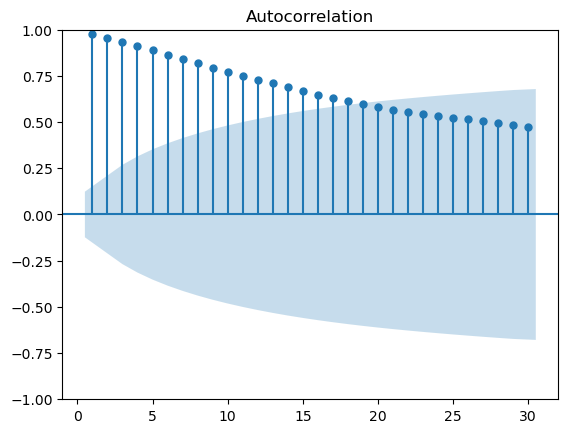

In [73]:
sgt.plot_acf(stock_data.NVO, lags = 30, zero = False)
plt.show()

## Partial Correlation Function

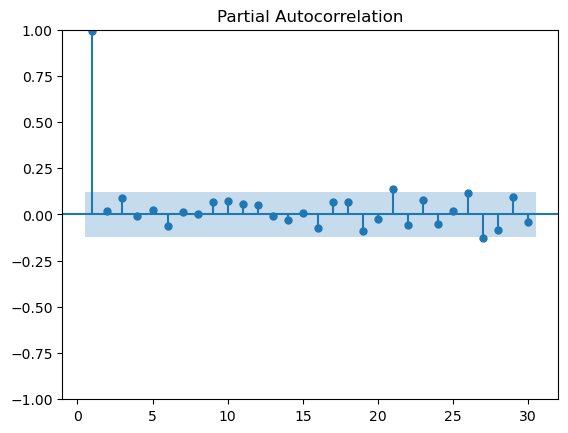

In [74]:
sgt.plot_pacf(stock_data.NVO, lags = 30, zero = False, method = ('ols'))
plt.show()

# Optimization Function

- This function optimizes the portfolios using the mean-variance analysis.

In [76]:
def optimization(data, no_of_portfolios):
    returns = data.pct_change()
    var_matrix = returns.cov()
    num_assets = len(data.columns)
    n = no_of_portfolios
    ind_returns = data.pct_change().mean() * 252
    
    port_weights_list = []
    port_variance_list = []
    port_voltality_list = []
    port_returns_list = []
    
    for port in range(n):
        port_weight = np.random.random(num_assets)
        port_weights = port_weight/np.sum(port_weight)
        portfolio_returns = ind_returns.dot(port_weights)
        port_variance = np.transpose(port_weights)@var_matrix@port_weights
        port_voltatlity = np.sqrt(port_variance)
        ann_volatility = port_voltatlity*(np.sqrt(252))
        port_weights_list.append(port_weights)
        port_variance_list.append(port_variance)
        port_voltality_list.append(ann_volatility)
        port_returns_list.append(portfolio_returns)
        
    final = {'Volatility' : port_voltality_list, 'Returns' : port_returns_list}

    for counter, symbol in enumerate(data.columns.tolist()):
        final[symbol + 'weights'] = [w[counter] for w in port_weights_list]

    optimized_data = pd.DataFrame.from_dict(final)
    return optimized_data

In [79]:
Optimized_portfolios = optimization(stock_data, 10000)
Optimized_portfolios.head(10)

Volatility   Returns  RTOweights  NVOweights  KRweights  BURLweights  \
0    0.191909  0.394840    0.120352    0.049830   0.081516     0.088554   
1    0.219436  0.516707    0.116760    0.114867   0.000163     0.034860   
2    0.202505  0.593454    0.071854    0.079624   0.085039     0.047888   
3    0.211907  0.483843    0.046053    0.039086   0.049140     0.094491   
4    0.212868  0.343091    0.145590    0.092469   0.067584     0.160671   
5    0.212332  0.438776    0.101852    0.018678   0.080469     0.086673   
6    0.183311  0.448693    0.095474    0.047678   0.105664     0.074570   
7    0.214976  0.546863    0.145603    0.111911   0.045741     0.023788   
8    0.208200  0.407823    0.116509    0.109293   0.032982     0.074695   
9    0.226126  0.438795    0.160278    0.102560   0.010448     0.046031   

   AGRweights  ARHSweights  ASXweights  AAPLweights  MSFTweights  METAweights  \
0    0.118967     0.053010    0.128372     0.115706     0.008312     0.070602   
1    0.082052     0.149997    0.112299     0.000335     0.077573     0.157951   
2    0.045968     0.045226    0.023866     0.089714     0.171226     0.147985   
3    0.118806     0.106320    0.031683     0.108977     0.116721     0.093476   
4    0.009984     0.132512    0.087091     0.082644     0.049566     0.007950   
5    0.123413     0.114303    0.039089     0.100716     0.057256     0.107215   
6    0.089027     0.071648    0.133411     0.029901     0.107317     0.148356   
7    0.052959     0.022889    0.151826     0.023101     0.117069     0.040205   
8    0.064225     0.142413    0.157003     0.055609     0.075072     0.036516   
9    0.106573     0.147535    0.006098     0.111426     0.053908     0.052999   

   DKNGweights  PLTRweights  
0     0.092724     0.072055  
1     0.087708     0.065435  
2     0.072767     0.118842  
3     0.074285     0.120963  
4     0.144264     0.019677  
5     0.044169     0.126167  
6     0.047725     0.049230  
7     0.176140     0.088768  
8     0.052405     0.083278  
9     0.071875     0.130270

# Volatility Optimization Function


In [80]:
def volatility_optimization(data):
    num_assets = len(data.columns)
    bounds = Bounds(0, 1)
    constraint_matrix = np.ones((1, num_assets))
    linear_constraint = LinearConstraint(constraint_matrix, [1], [1])
    initial_weights = np.ones(num_assets) / num_assets
    ind_returns = data.pct_change().mean() * 252
    var_matrix = data.pct_change().cov()
    
    def port_vol(weights):
        return np.sqrt(np.dot(np.transpose(weights), np.dot(weights, var_matrix))*252)
    
    vol = minimize(port_vol, initial_weights, method= 'trust-constr', constraints= linear_constraint, bounds=bounds)
    min_wei = vol.x
    min_vol = port_vol(min_wei)
    port_returns = ind_returns.dot(min_wei)
    final_weight = np.transpose(min_wei)[np.newaxis]
    final_weights = pd.DataFrame(final_weight)
    final_weights.columns = stock_data.columns
    final_weights['Volatility'] = min_vol
    final_weights['Return'] = port_returns
    return final_weights

In [81]:
least_volatility = volatility_optimization(stock_data)
least_volatility

RTO       NVO        KR      BURL       AGR      ARHS       ASX  \
0  0.021717  0.121157  0.373123  0.004971  0.092393  0.000002  0.044768   

       AAPL      MSFT      META          DKNG          PLTR  Volatility  \
0  0.217218  0.123407  0.001244  6.075272e-07  8.048189e-07    0.120086   

    Return  
0  0.26691

# Sharpe_ratio Optimization Function

In [82]:
def Sharpe_ratio_optimization(data, risk_free_rate):
    num_assets = len(data.columns)
    bounds = Bounds(0, 1)
    rf = risk_free_rate
    constraint_matrix = np.ones((1, num_assets))
    linear_constraint = LinearConstraint(constraint_matrix, [1], [1])
    initial_weights = np.ones(num_assets) / num_assets
    ind_returns = data.pct_change().mean() * 252
    var_matrix = data.pct_change().cov()
    
    def port_vol(weights):
        return np.sqrt(np.dot(np.transpose(weights), np.dot(weights, var_matrix))*252)
    
    def inv_sharpe(weights):
        return  (np.sqrt(np.dot(np.transpose(weights), np.dot(weights, var_matrix))*252)) / (ind_returns.dot(weights) - rf) 
    
    opt = minimize(inv_sharpe, initial_weights, method='trust-constr', constraints= linear_constraint, bounds=bounds)
    min_wei = opt.x
    vol = port_vol(min_wei)
    returns = ind_returns.dot(min_wei)
    wei = np.transpose(min_wei)[np.newaxis]
    f_wei = pd.DataFrame(wei)
    f_wei.columns = data.columns
    f_wei['Volatility'] = vol
    f_wei['Return'] = returns
    return f_wei

In [84]:
optimal_sharpe = Sharpe_ratio_optimization(stock_data, 0.01)
optimal_sharpe

RTO       NVO       KR          BURL           AGR          ARHS  \
0  2.725018e-07  0.228109  0.26065  3.672544e-07  4.579607e-07  3.138397e-07   

        ASX          AAPL      MSFT      META     DKNG      PLTR  Volatility  \
0  0.003993  7.659786e-07  0.139663  0.262111  0.04603  0.059441      0.1754   

     Return  
0  0.678878

#### Upon optimizing the portfolio based on the sharpe ratio, we can see that the optimal risk to take for this portfolio is **17.52%** to achieve a return of **67.88%**.

# Frontier Curve Visualization

<Axes: xlabel='Volatility', ylabel='Returns'>

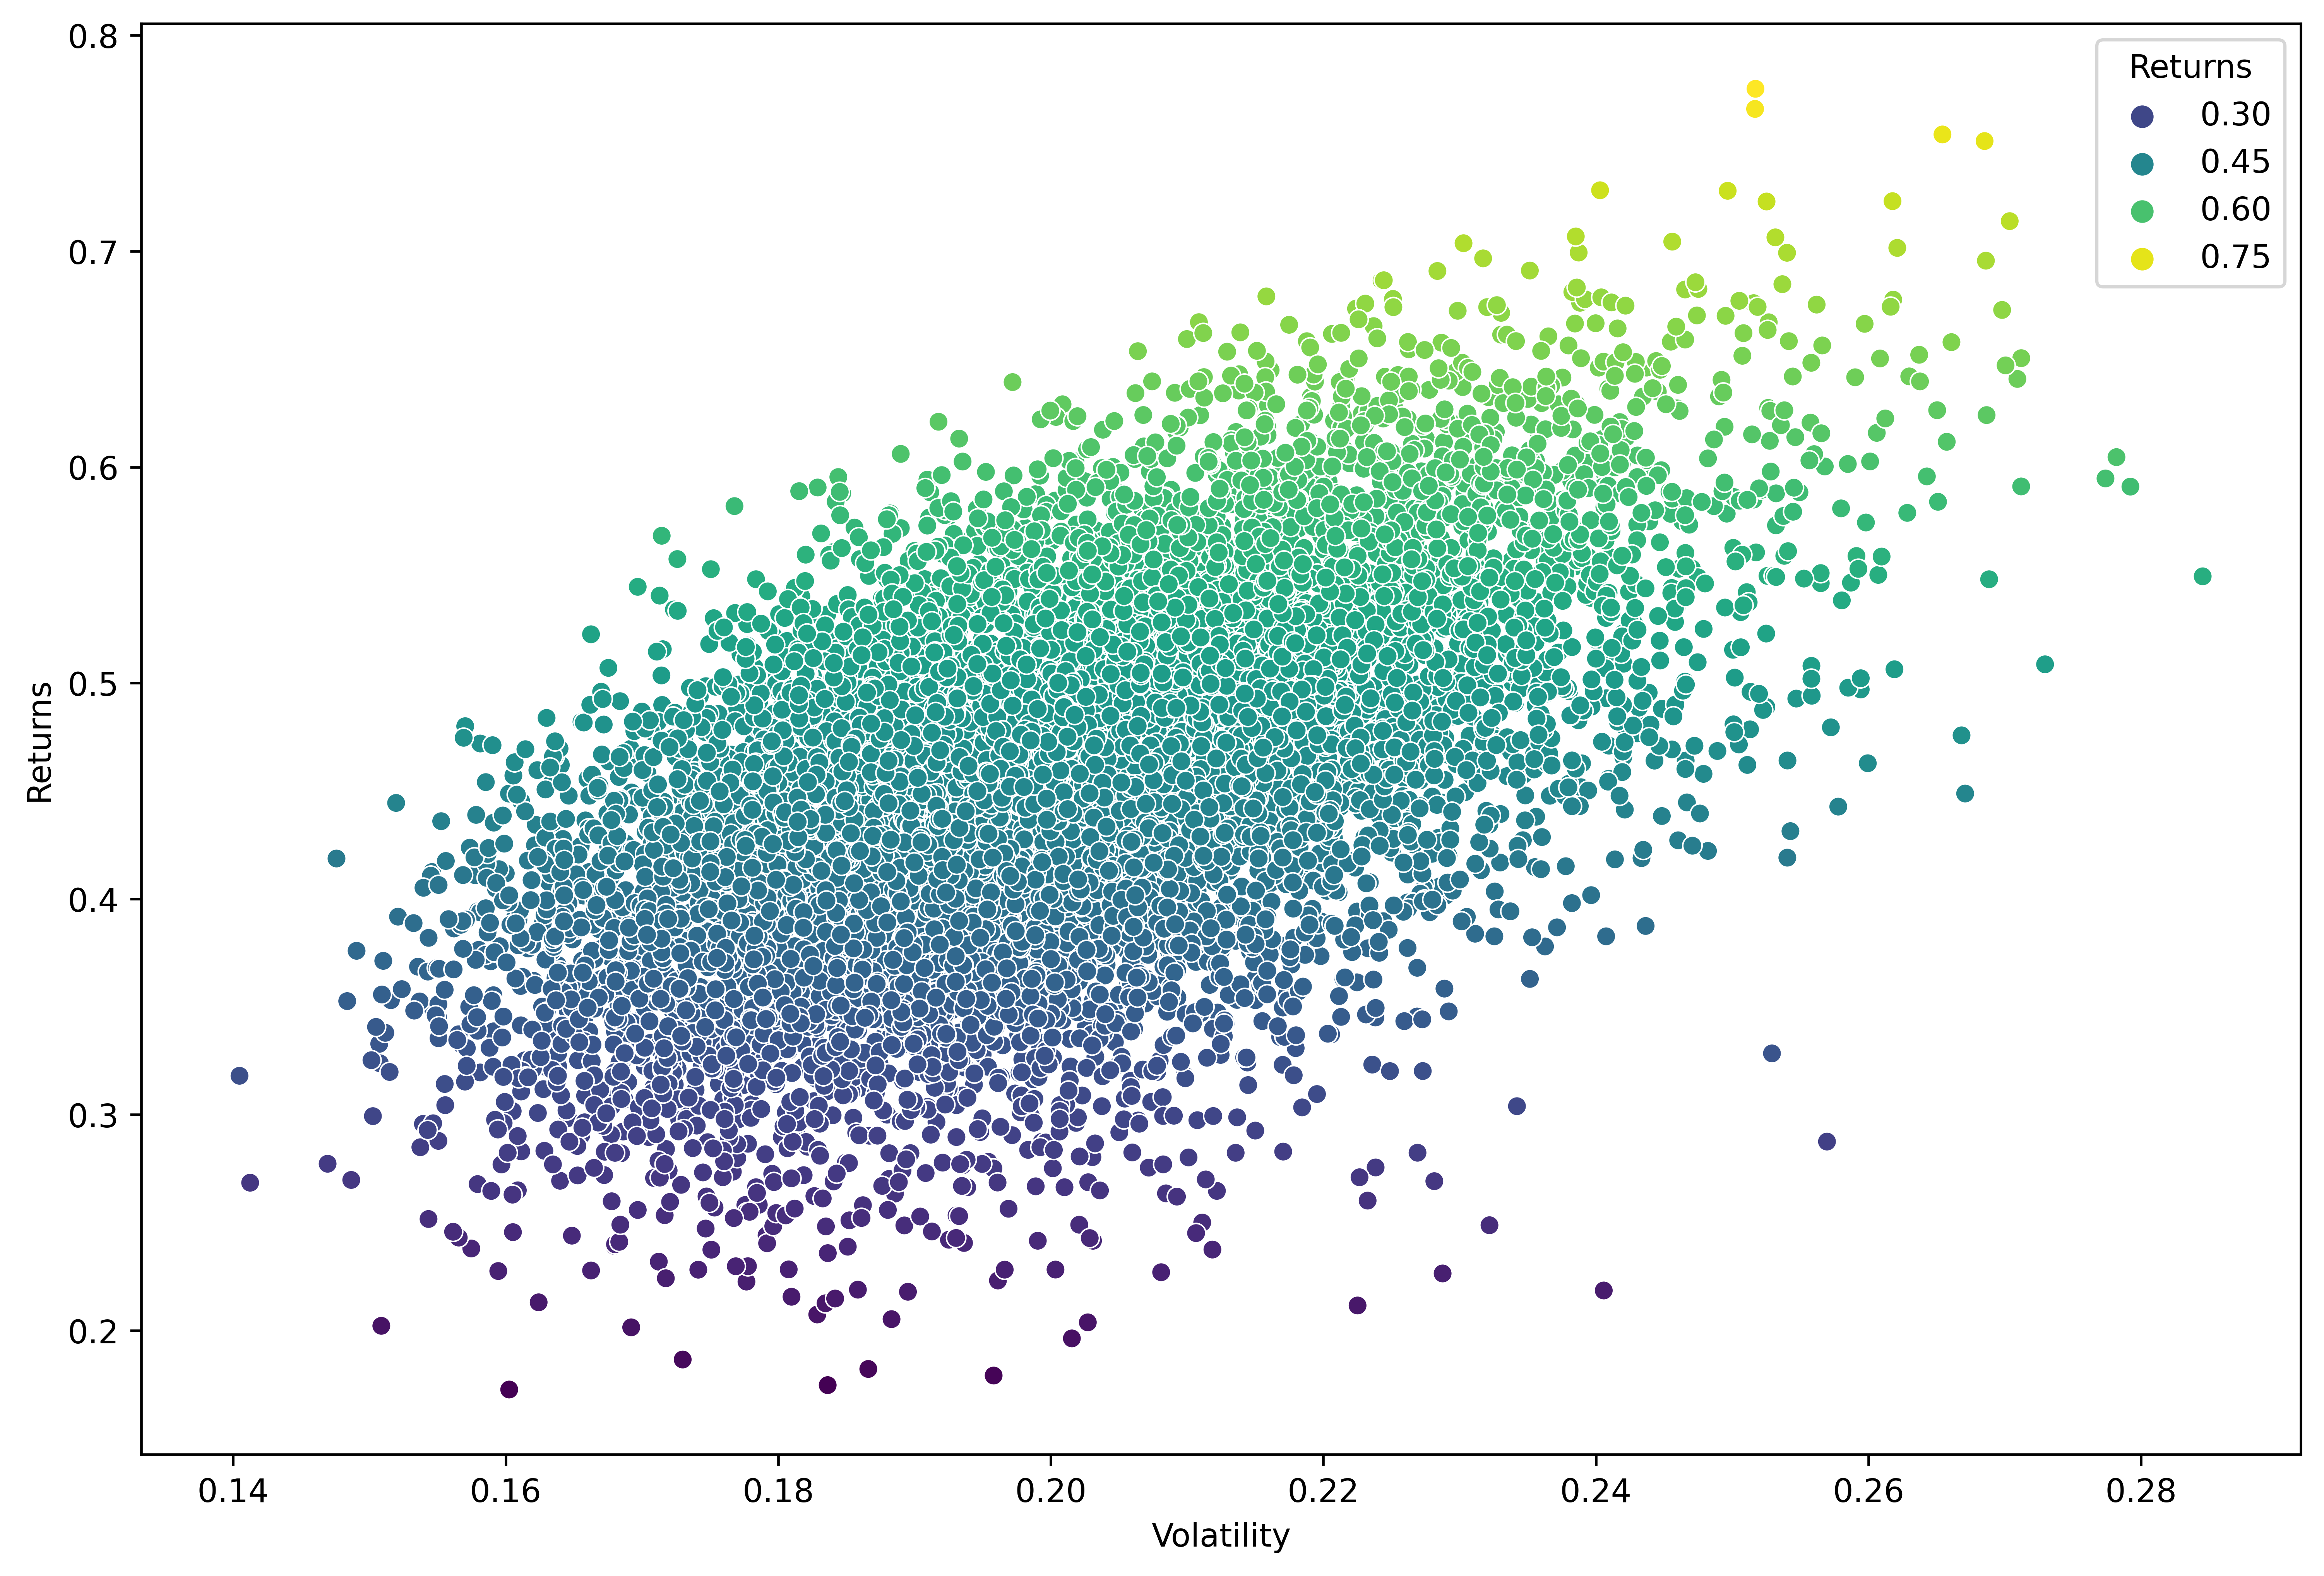

In [85]:
plt.figure(figsize=(12,8), dpi=600)
sns.scatterplot(data=Optimized_portfolios, x= 'Volatility', y= 'Returns', hue= 'Returns', palette='viridis')